In [2]:
import pandas as pd
actual = pd.read_csv("/kaggle/input/data-files/test_data_118.csv")
generated = pd.read_csv("/kaggle/input/data-files/gen_data_118.csv")

In [3]:
pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 pandapower==2.14.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 64.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 41.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

In [5]:

import numpy as np
import pandas as pd
from scipy.stats import entropy
import pandapower as pp

net = pp.networks.case118()

actual_nonpu = actual.copy()
generated_nonpu = generated.copy()

BASE_MVA = 100

p_cols = [c for c in actual.columns if c.startswith("P")]
q_cols = [c for c in actual.columns if c.startswith("Q")]
v_cols = [c for c in actual.columns if c.startswith("V")]
theta_cols = [c for c in actual.columns if c.startswith("Th")]

# Convert P and Q (per-unit → MW / Mvar)
for col in p_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

for col in q_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

# Convert V (per-unit → kV)
vn_kv = net.bus.vn_kv.values  # base voltage for each bus
for i, col in enumerate(v_cols):
    actual_nonpu[col] = actual[col] * vn_kv[i]
    generated_nonpu[col] = generated[col] * vn_kv[i]

def kl_divergence_featurewise(actual_df, generated_df, bins=80, eps=1e-12):
    """
    Computes KL divergence for each feature:
       KL( real_feature || gen_feature )
    Uses histogram approximation.
    """
    kl_results = {}

    for col in actual_df.columns:
        real_vals = actual_df[col].values
        gen_vals  = generated_df[col].values

        # Shared histogram binning
        hist_range = (min(real_vals.min(), gen_vals.min()),
                      max(real_vals.max(), gen_vals.max()))

        real_hist, bin_edges = np.histogram(real_vals, bins=bins, range=hist_range, density=True)
        gen_hist,  _         = np.histogram(gen_vals,  bins=bins, range=hist_range, density=True)

        # Avoid division issues
        real_hist += eps
        gen_hist  += eps

        # Normalize
        real_hist /= real_hist.sum()
        gen_hist  /= gen_hist.sum()

        # KL(real || gen)
        kl = entropy(real_hist, gen_hist)  
        kl_results[col] = kl

    return pd.DataFrame(kl_results, index=["KL"]).T


# Run KL divergence
kl_results_df = kl_divergence_featurewise(actual_nonpu, generated_nonpu)

print(kl_results_df)
print("\nMean KL divergence:", kl_results_df["KL"].mean())

                KL
P0        0.149144
P1        0.206858
P2        0.196065
P3        0.540826
P4        0.862750
P5        0.259102
P6        0.142736
P7        0.238480
P8        0.903868
P9        0.165045
P10       0.220384
P11       0.243140
P12       0.296589
P13       0.191847
P14       0.183996
P15       0.203002
P16       0.237979
P17       0.246728
P18       0.117006
P19       0.193075
P20       0.244313
P21       0.198098
P22       0.183252
P23       0.169497
P24       0.267041
P25       0.267400
P26       0.203615
P27       0.221898
P28       0.174174
P29       1.044124
P30       0.160388
P31       0.196475
P32       0.172534
P33       0.233605
P34       0.456685
P35       0.250685
P36       0.767871
P37       1.177655
P38       0.550665
P39       0.231528
P40       0.196210
P41       0.129655
P42       0.179294
P43       0.209753
P44       0.215622
P45       0.224193
P46       0.185124
P47       0.179526
P48       0.187033
P49       0.199223
P50       0.635021
P51       0.

In [6]:
import ot
from scipy.spatial.distance import cdist

assert list(actual.columns) == list(generated.columns), "Columns mismatch!"

distances = []
num_bus = 6
cols = [f"P{i}" for i in range(num_bus)] + [f"Theta{i}" for i in range(num_bus)]
data_gt = actual[cols].values
data_syn = generated[cols].values

n = len(data_gt)
m = len(data_syn)

a = np.ones(n) / n
b = np.ones(m) / m

M = cdist(data_gt, data_syn, metric='euclidean')

wasserstein_dist = ot.emd2(a, b, M)
distances.append(wasserstein_dist)

print("P Theta W1 distance:", wasserstein_dist)

cols = [f"Q{i}" for i in range(num_bus)] + [f"V{i}" for i in range(num_bus)]
data_gt = actual[cols].values
data_syn = generated[cols].values

n = len(data_gt)
m = len(data_syn)

a = np.ones(n) / n
b = np.ones(m) / m

M = cdist(data_gt, data_syn, metric='euclidean')

wasserstein_dist = ot.emd2(a, b, M)
distances.append(wasserstein_dist)

print("Q V W1 distance:", wasserstein_dist)
cols = [f"P{i}" for i in range(num_bus)] + [f"Q{i}" for i in range(num_bus)] + [f"V{i}" for i in range(num_bus)] + [f"Theta{i}" for i in range(num_bus)]
data_gt = actual[cols].values
data_syn = generated[cols].values

n = len(data_gt)
m = len(data_syn)

a = np.ones(n) / n
b = np.ones(m) / m

M = cdist(data_gt, data_syn, metric='euclidean')

wasserstein_dist = ot.emd2(a, b, M)


print("Average:", np.mean(distances))


2025-11-22 03:11:45.376350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763781105.641739      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763781105.721131      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

P Theta W1 distance: 0.17185253371140502
Q V W1 distance: 0.004943703758885736
Average: 0.08839811873514537



Detected 118 buses based on column naming (P1...P118).

Converted per-unit values to actual units (MW / Mvar / kV / degrees)


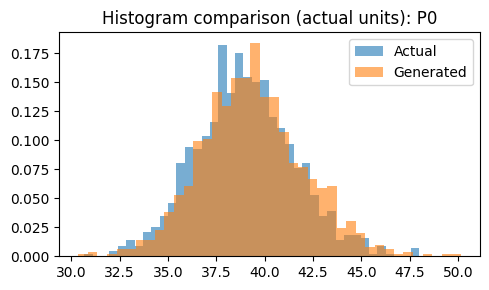

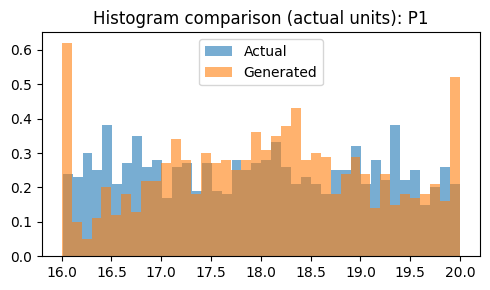

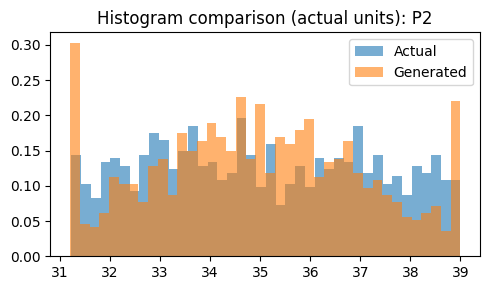

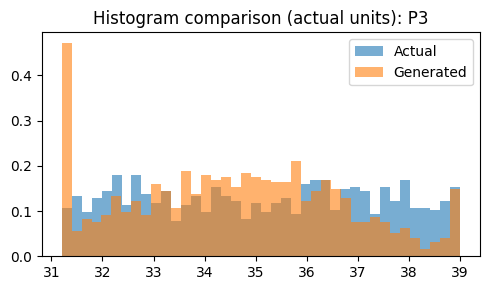

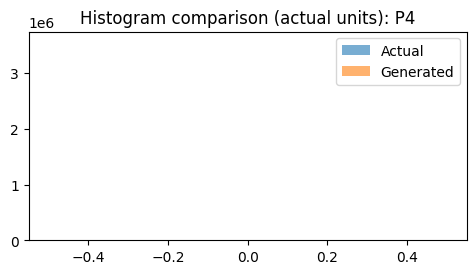

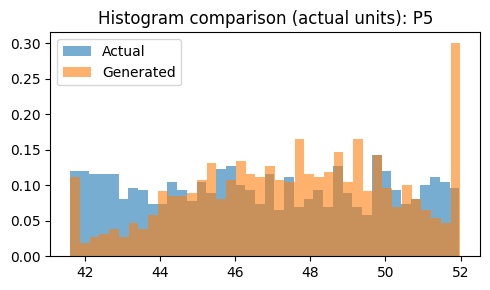

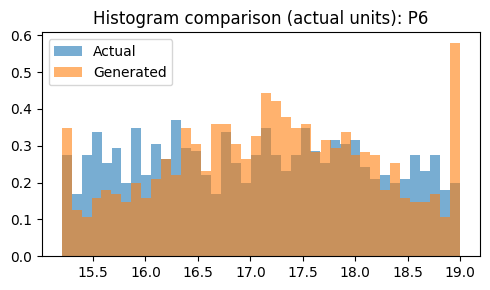

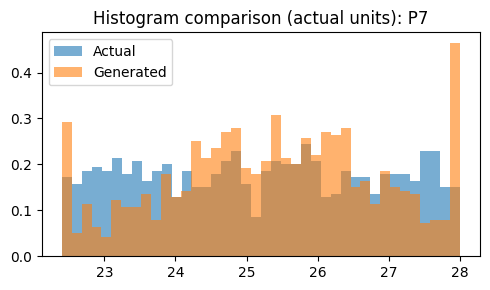

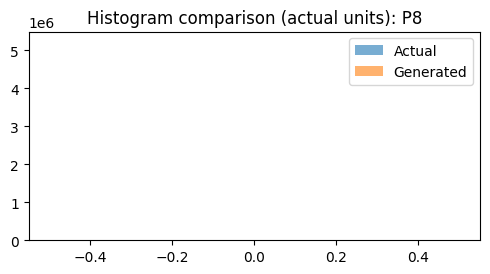

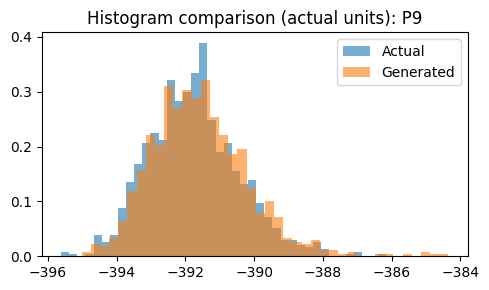

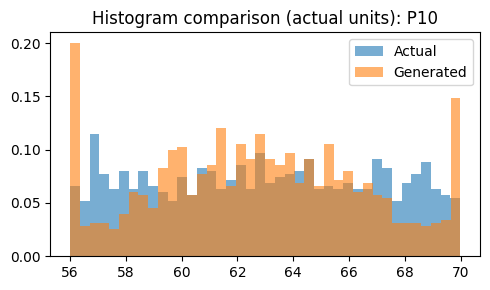

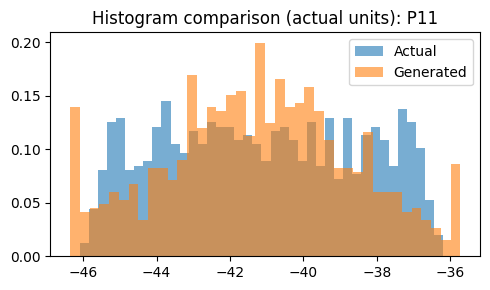

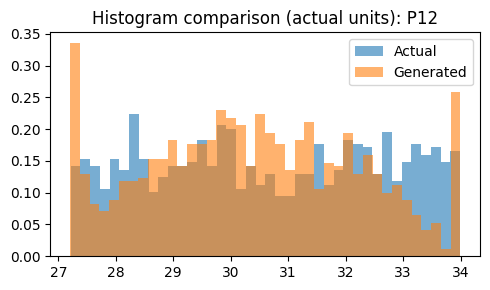

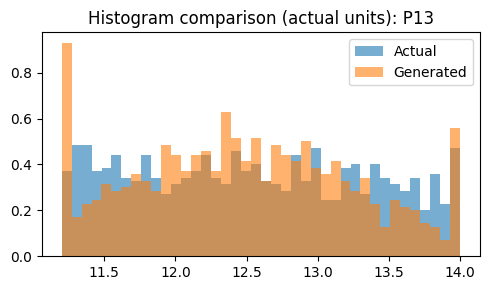

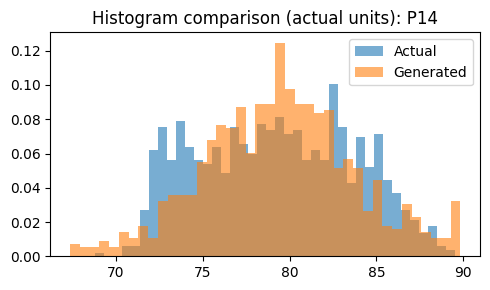

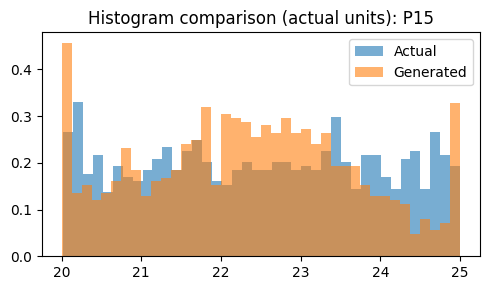

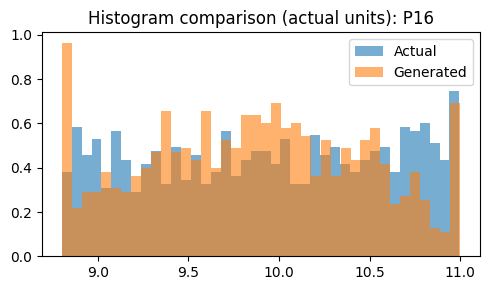

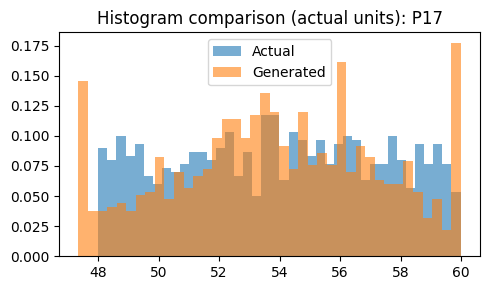

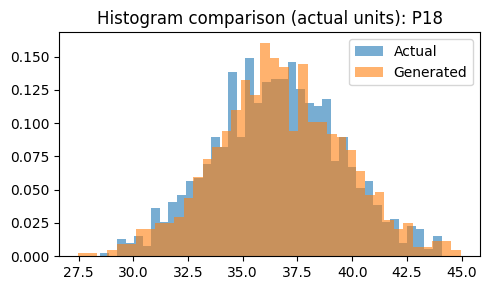

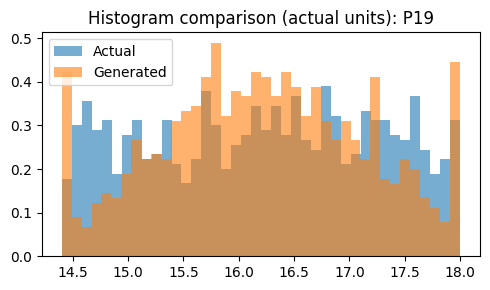

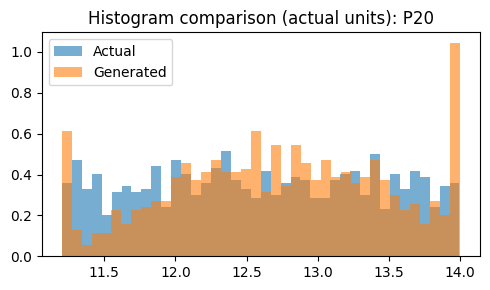

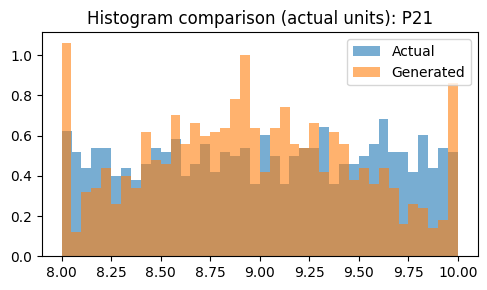

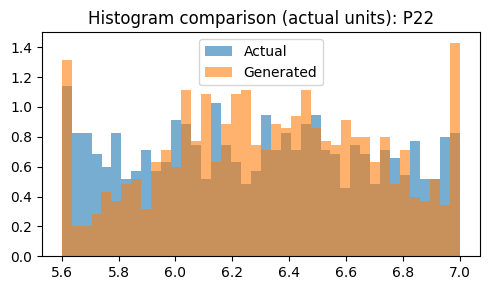

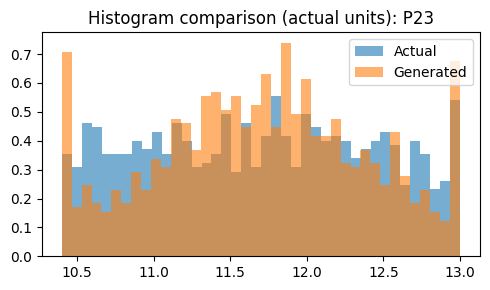

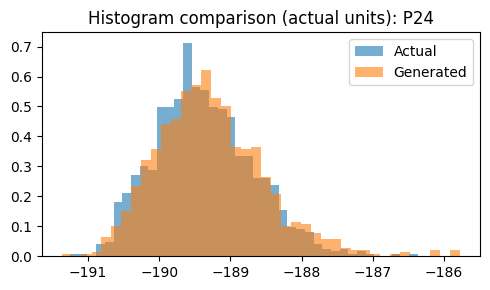

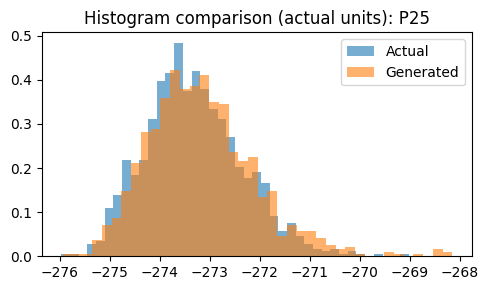

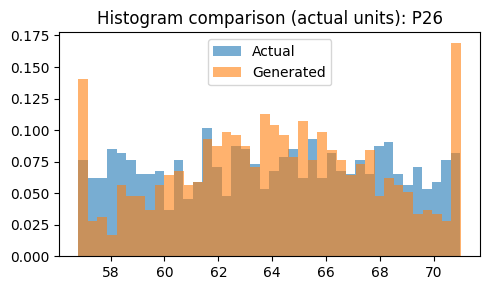

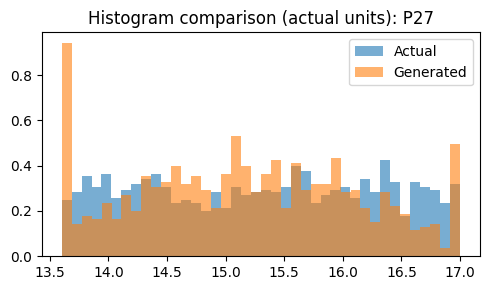

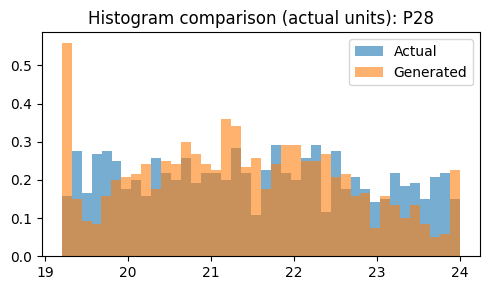

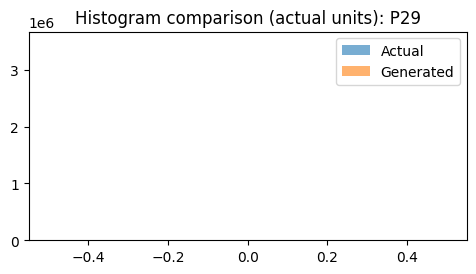

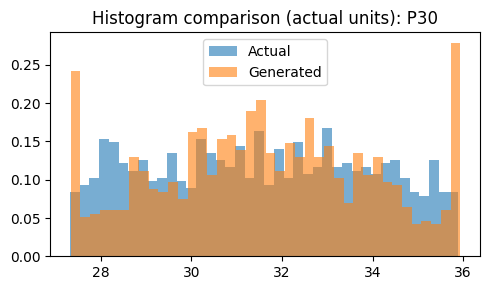

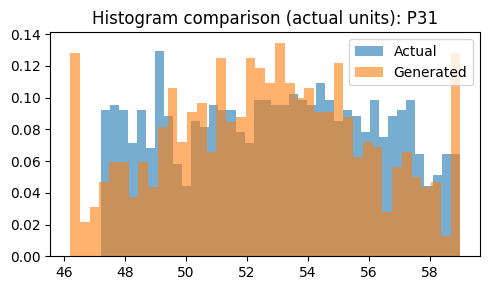

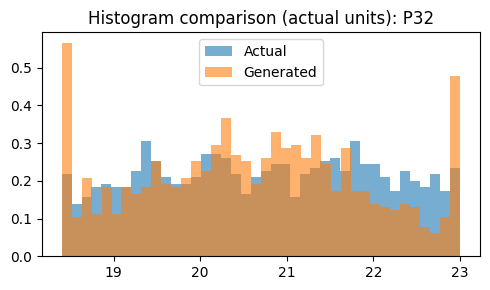

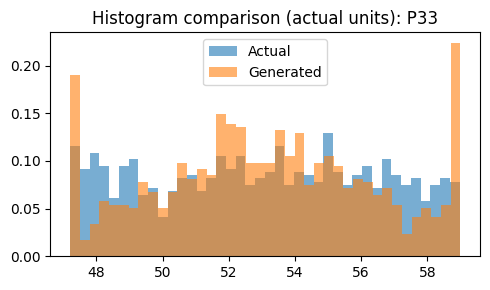

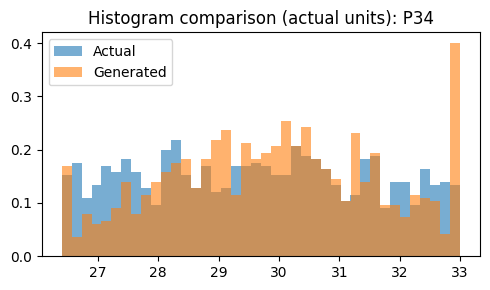

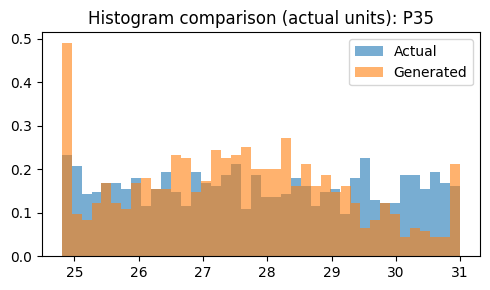

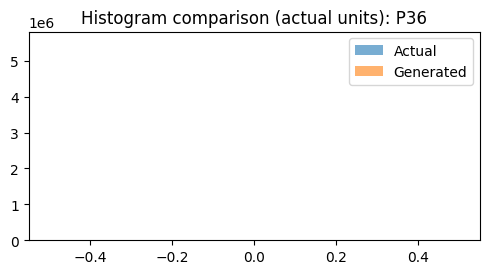

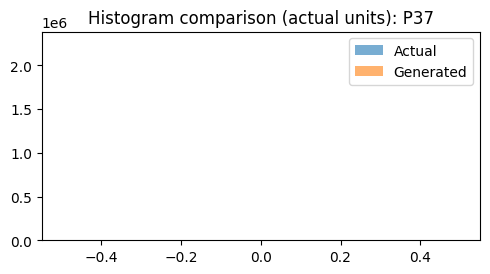

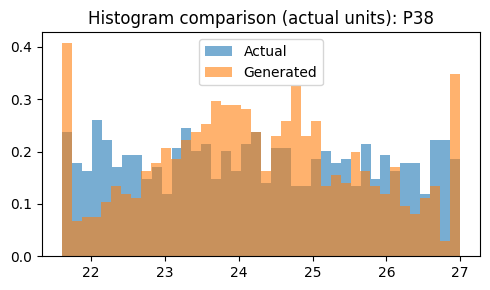

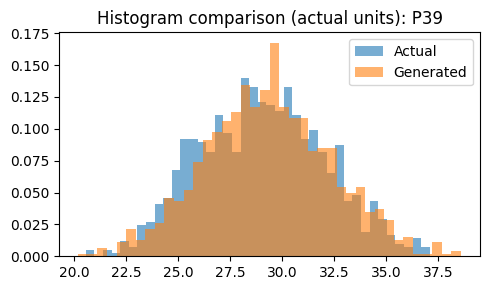

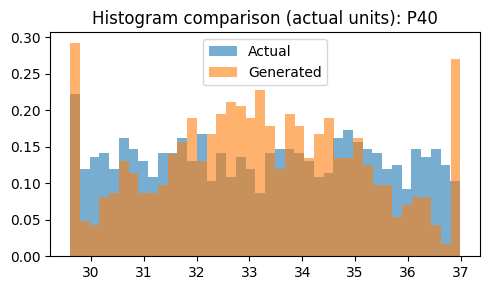

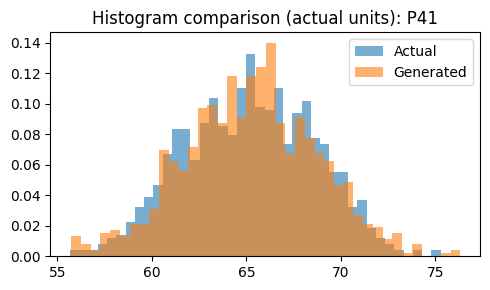

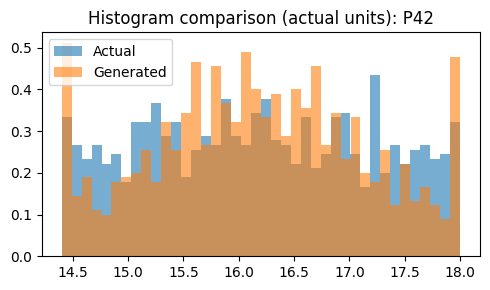

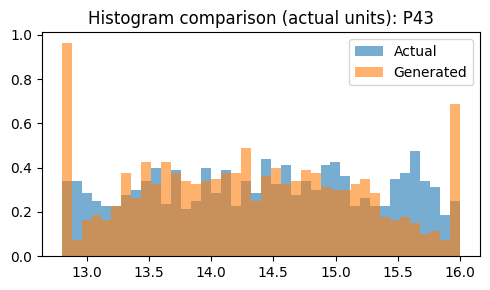

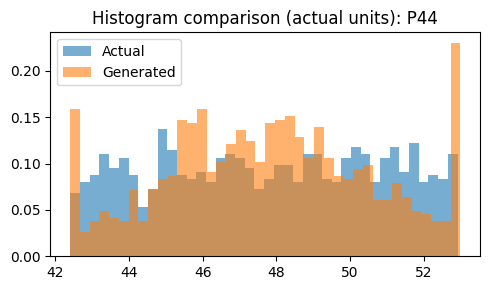

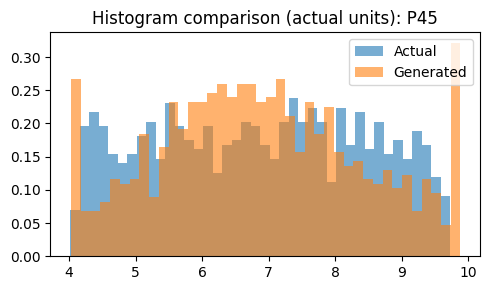

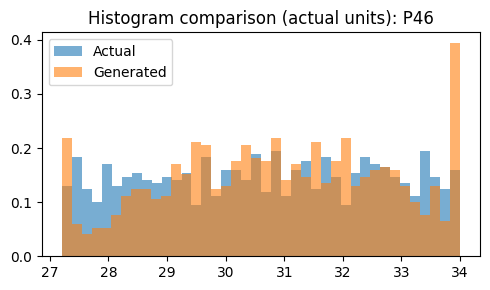

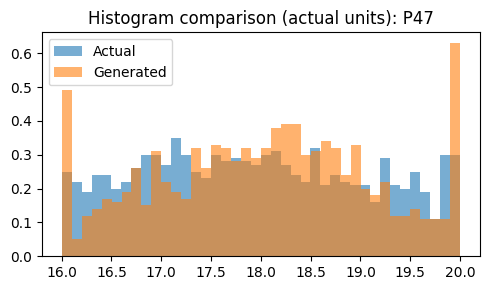

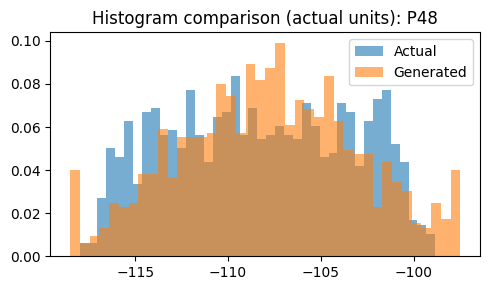

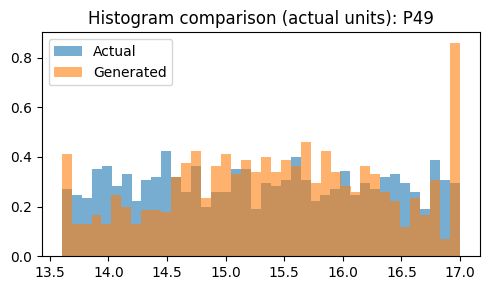

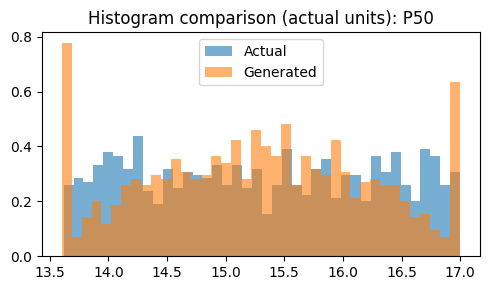

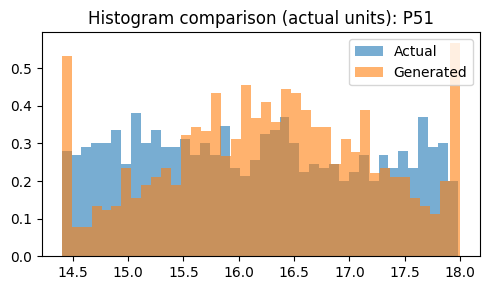

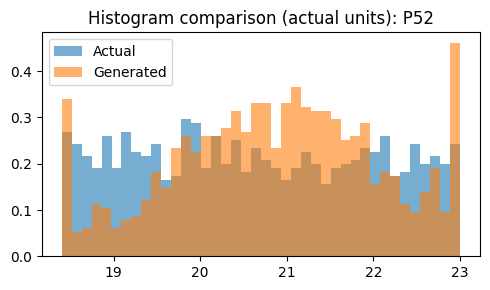

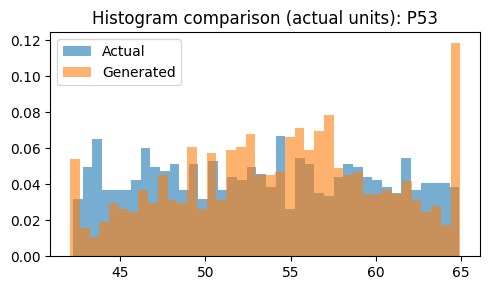

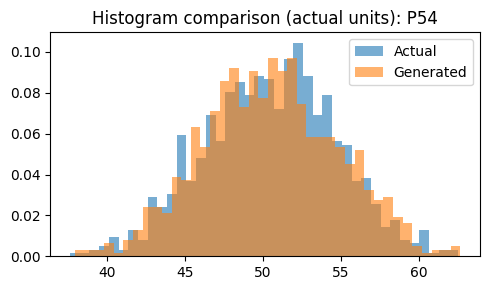

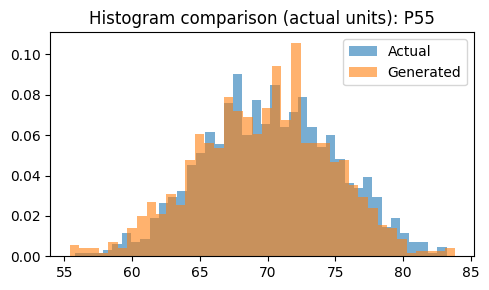

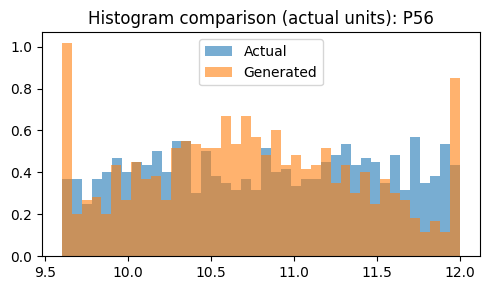

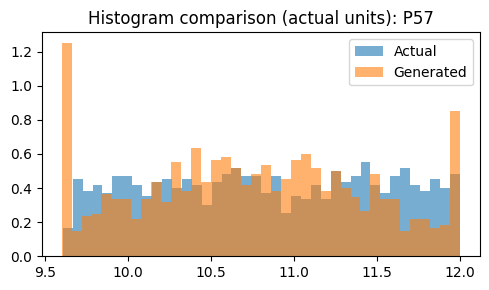

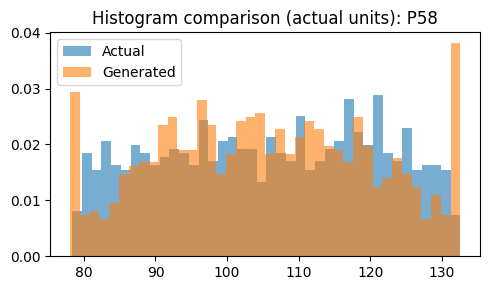

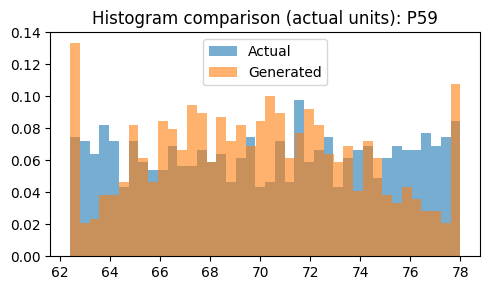

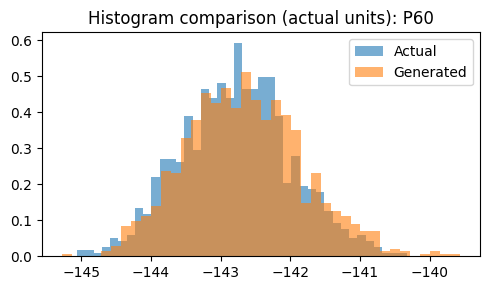

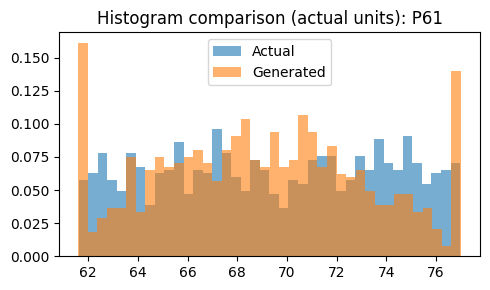

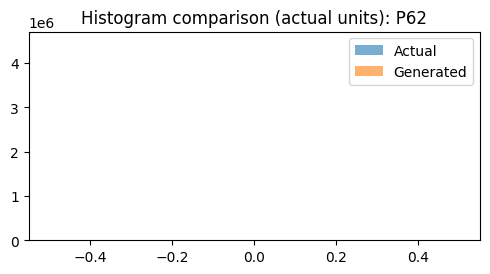

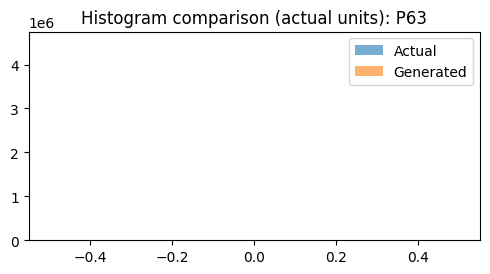

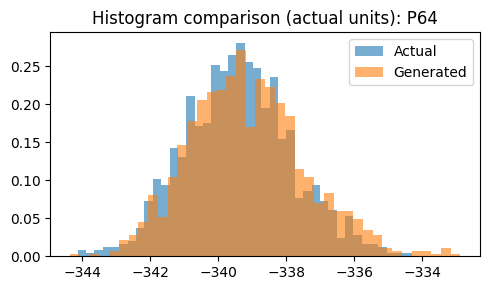

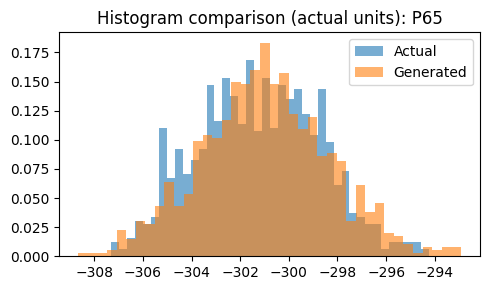

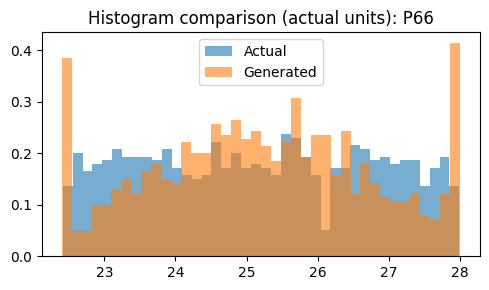

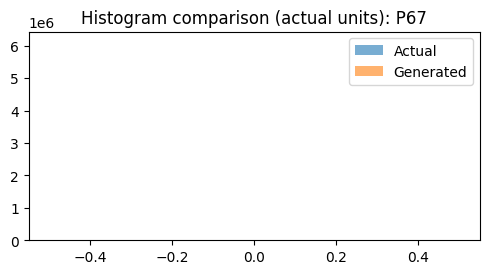

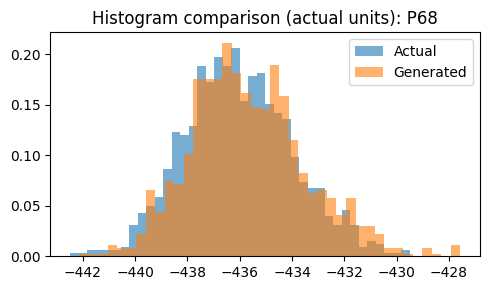

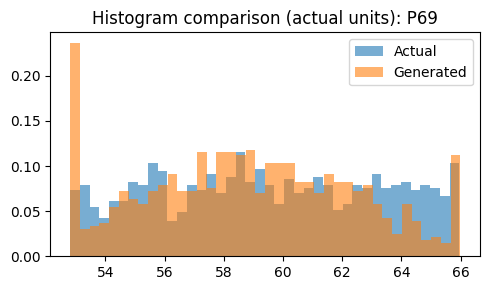

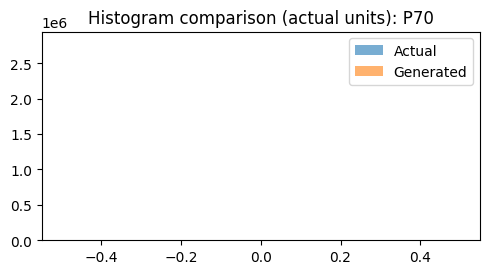

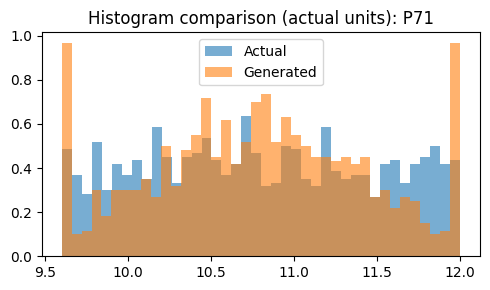

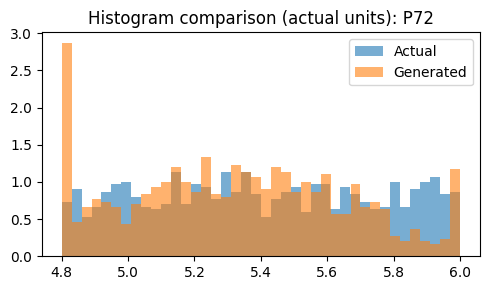

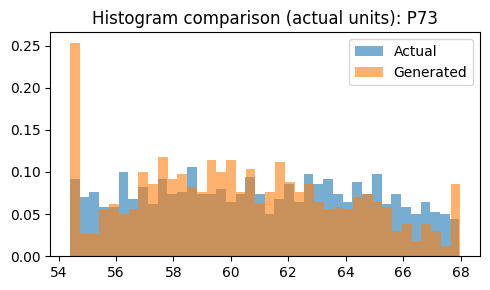

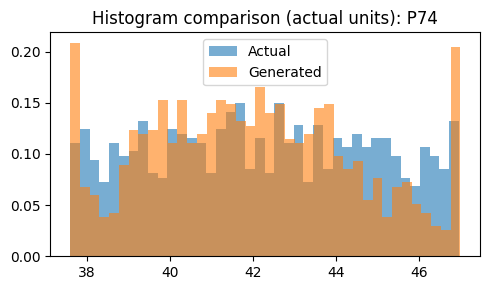

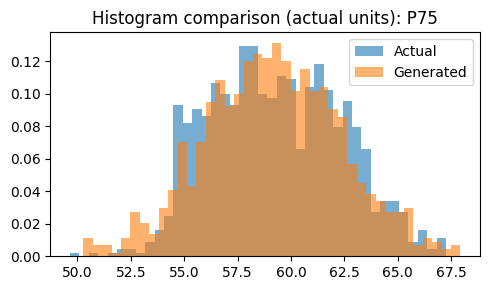

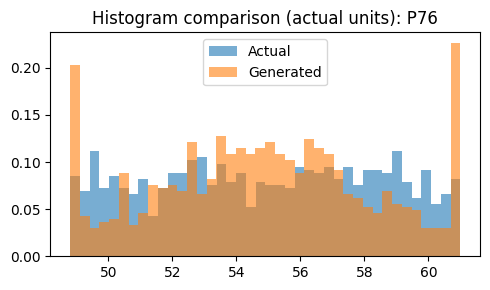

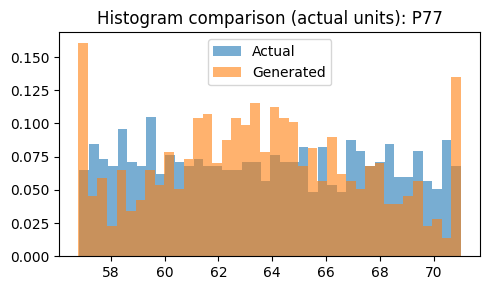

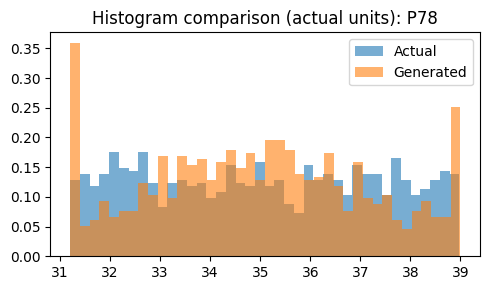

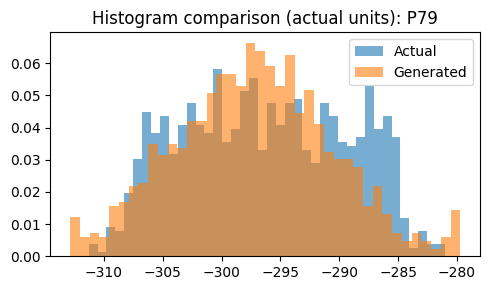

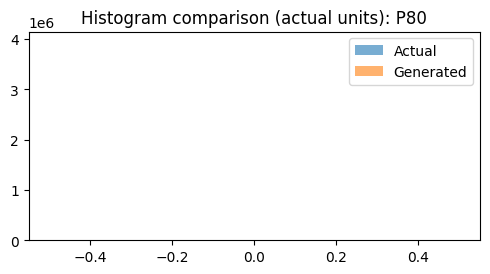

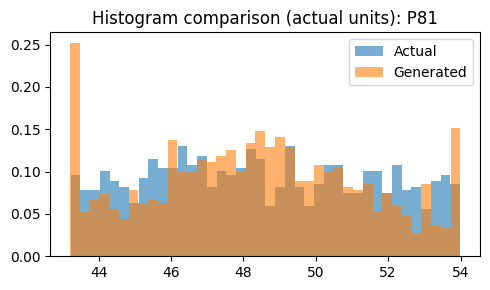

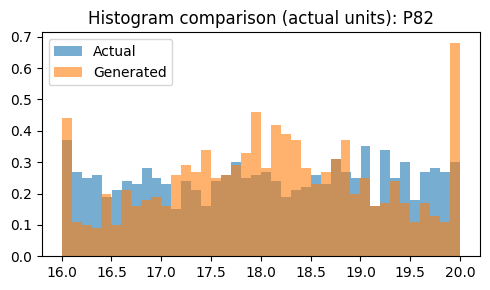

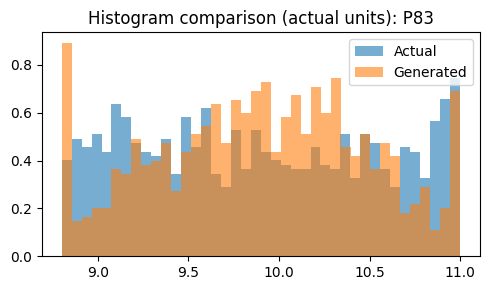

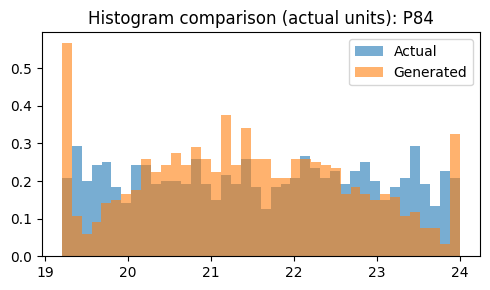

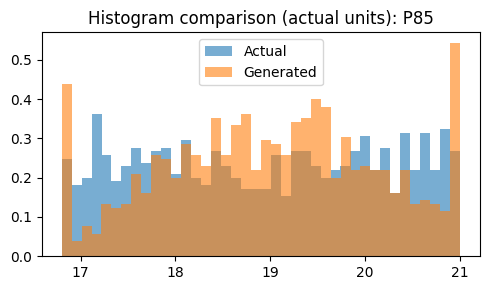

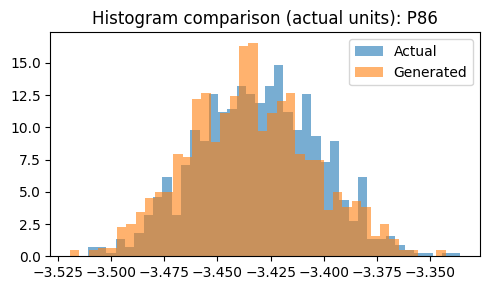

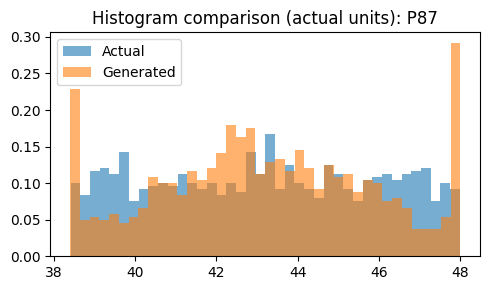

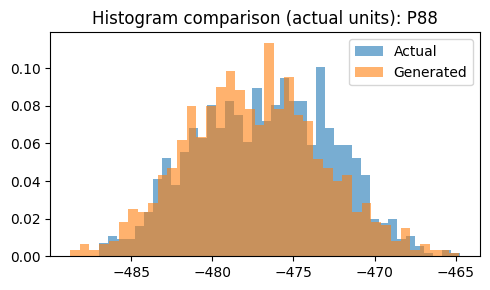

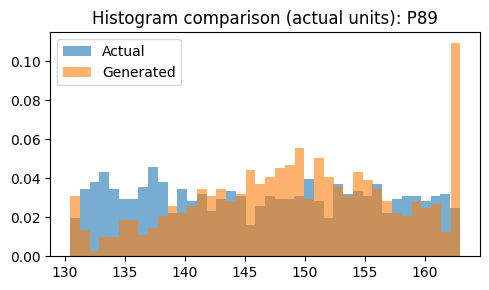

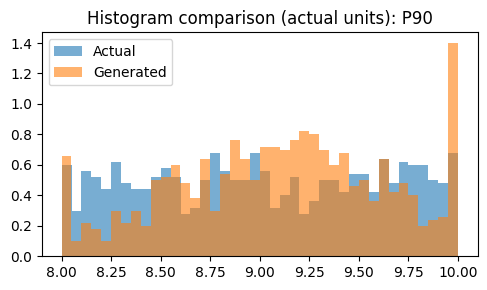

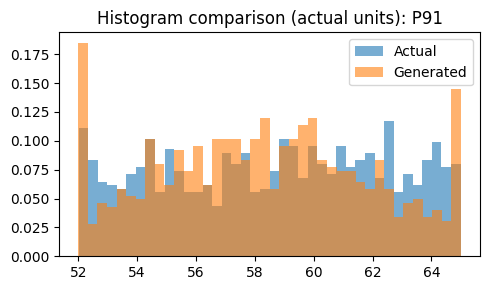

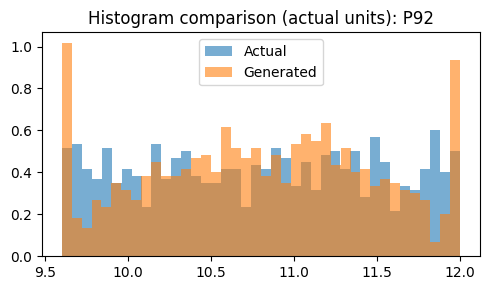

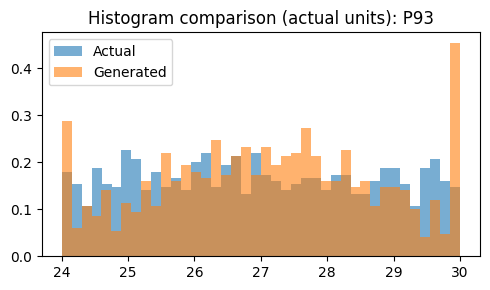

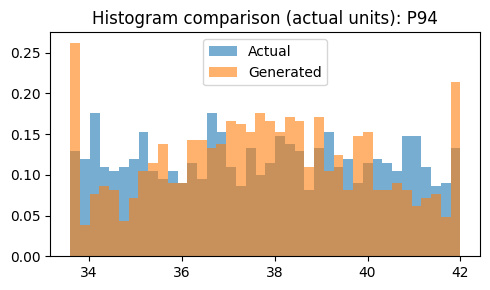

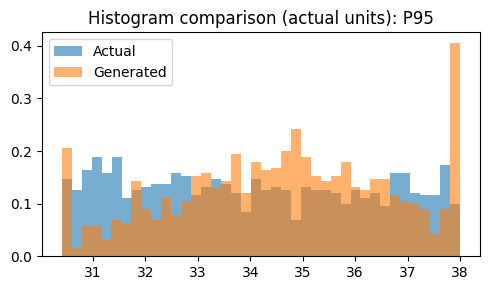

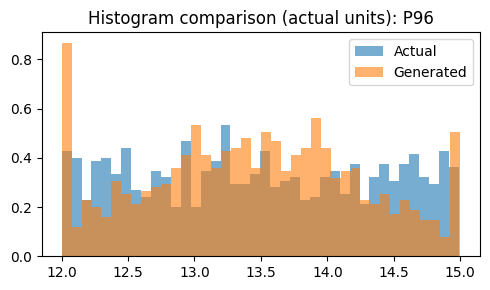

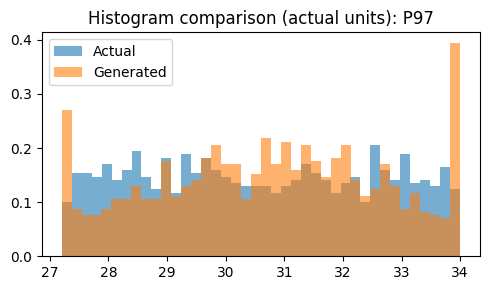

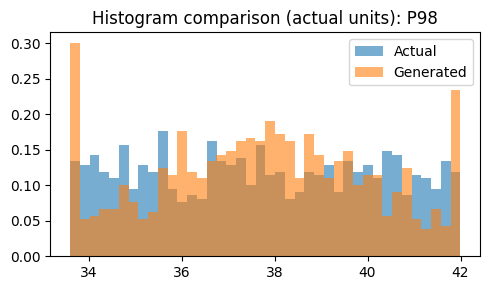

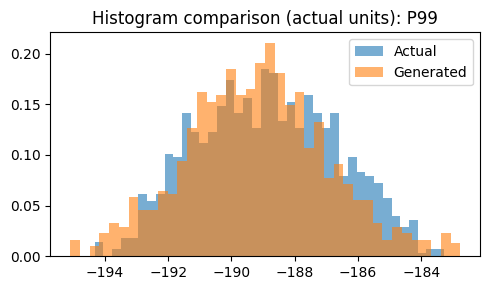

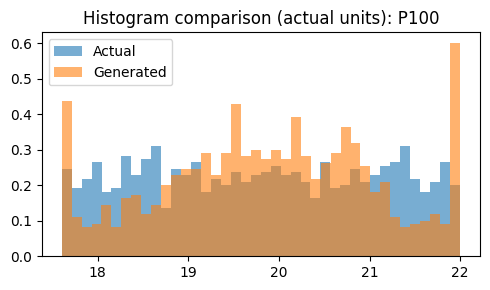

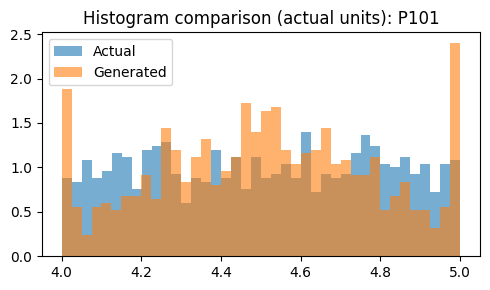

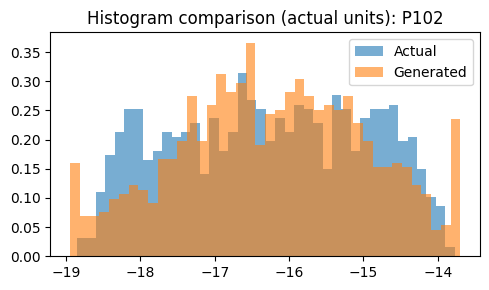

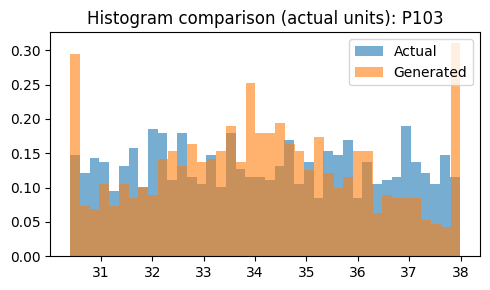

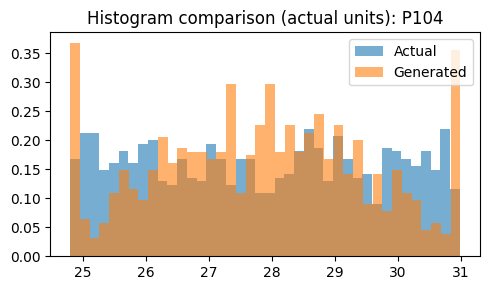

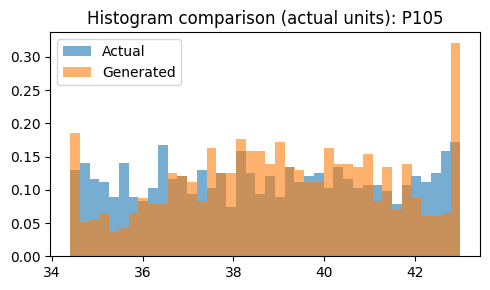

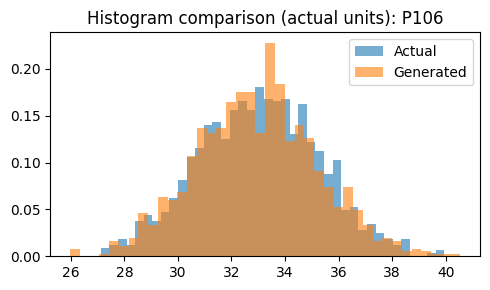

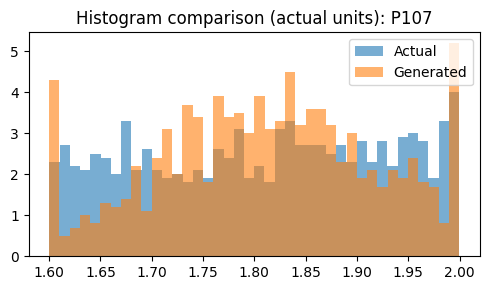

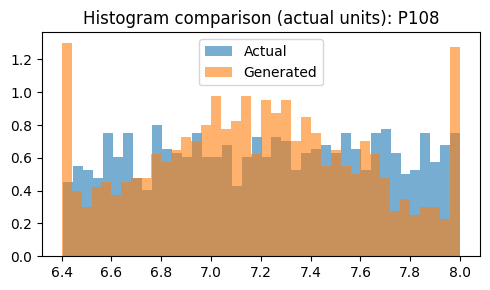

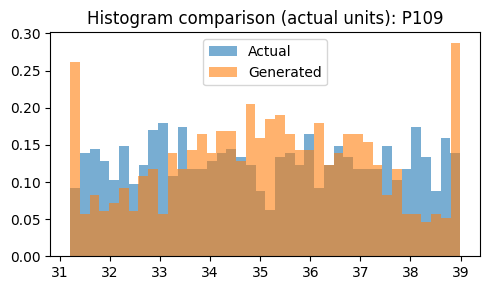

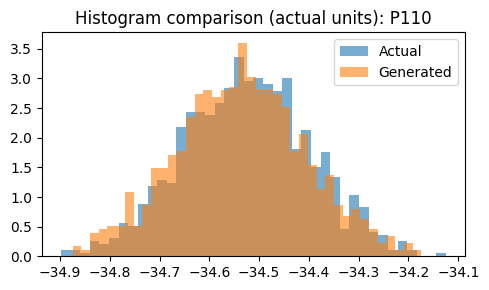

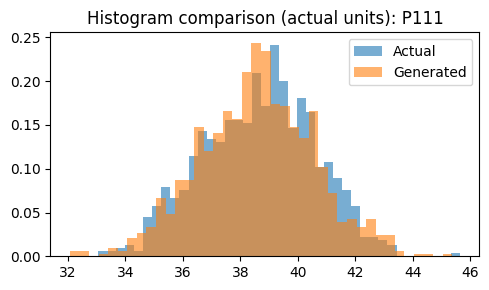

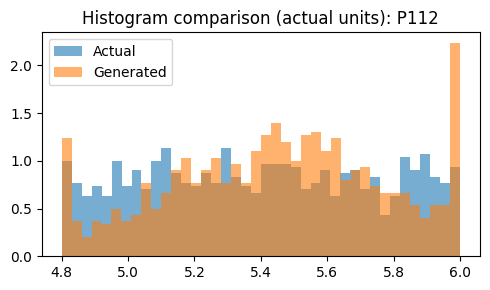

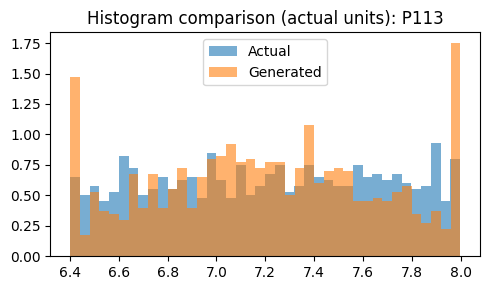

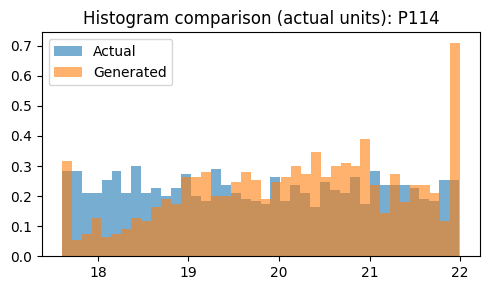

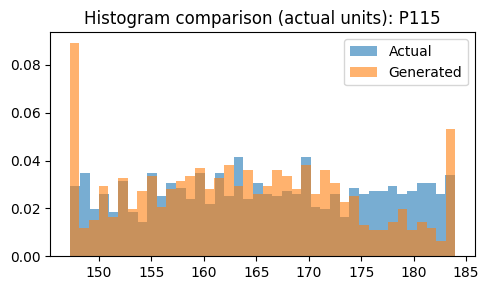

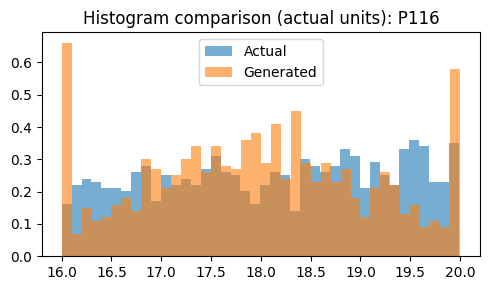

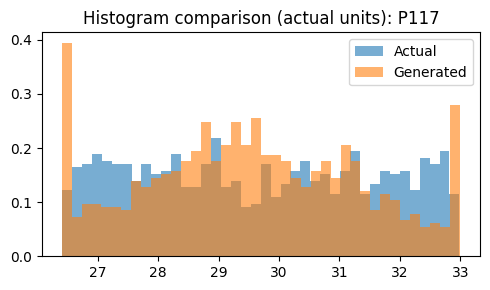

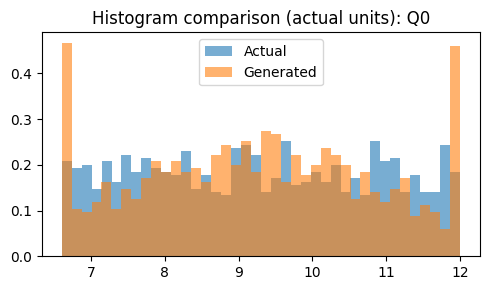

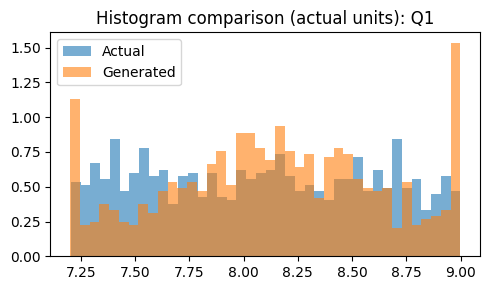

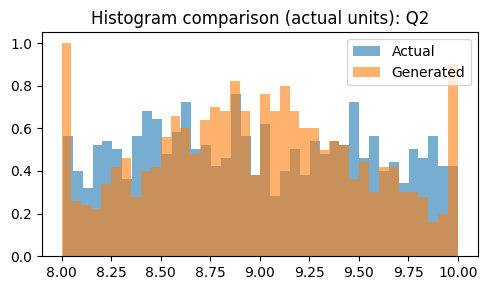

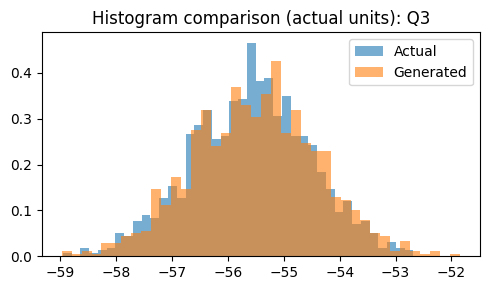

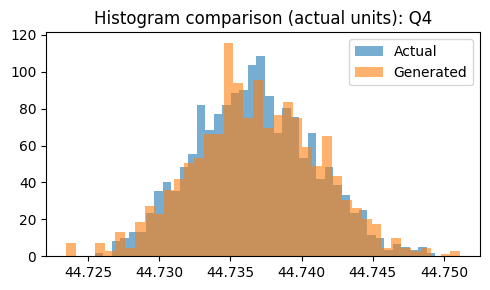

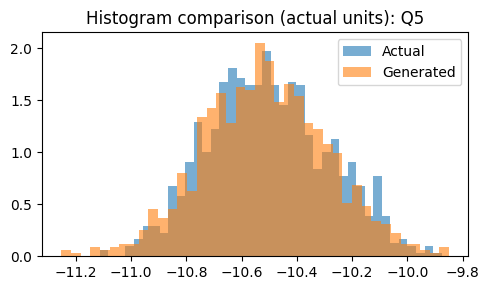

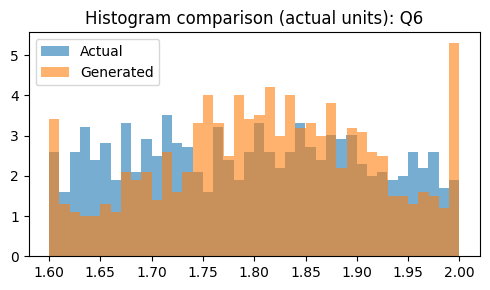

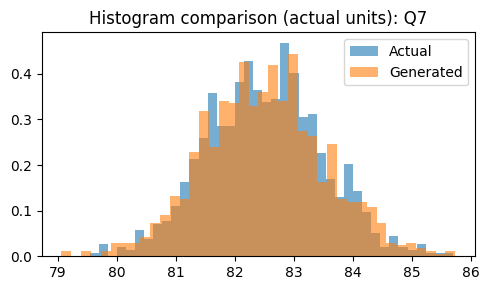

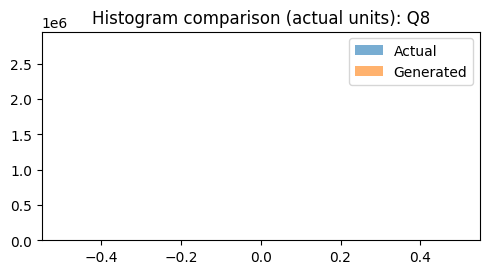

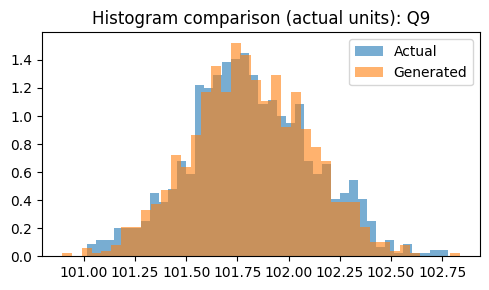

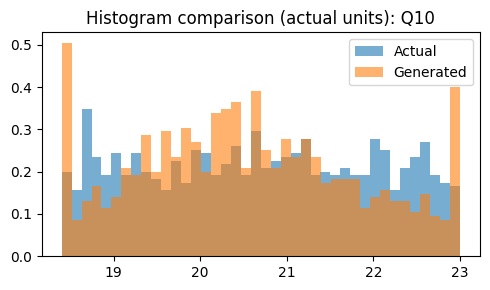

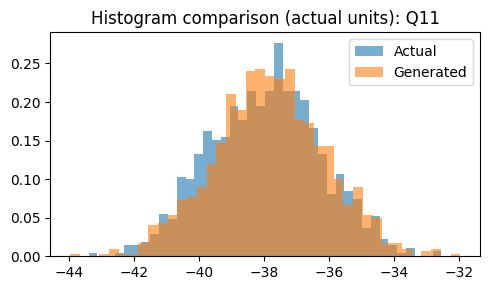

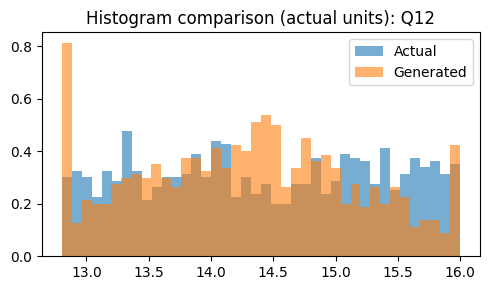

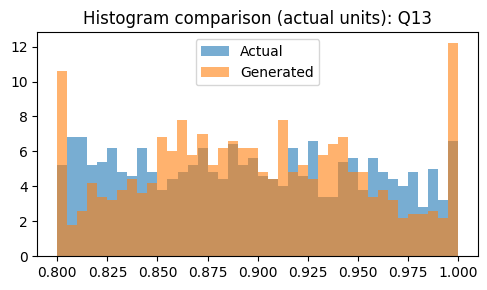

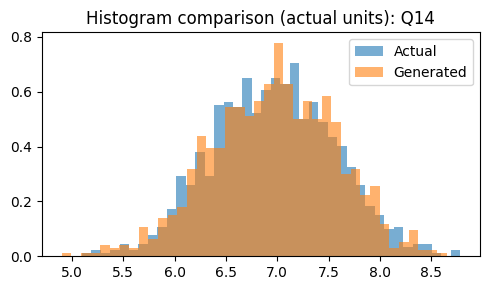

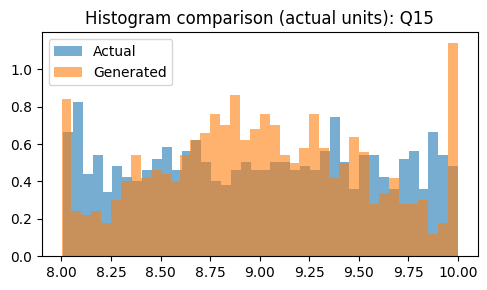

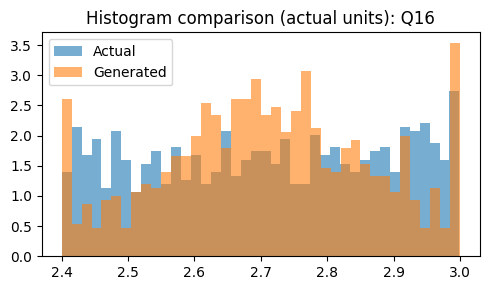

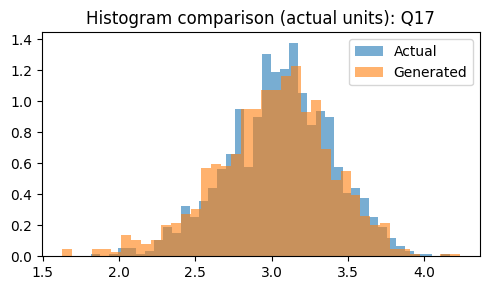

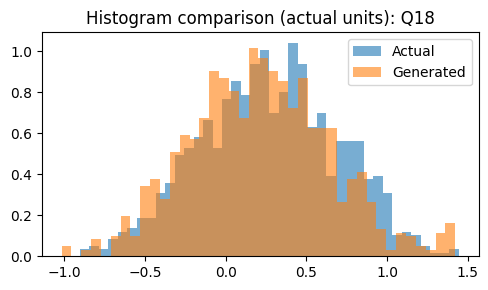

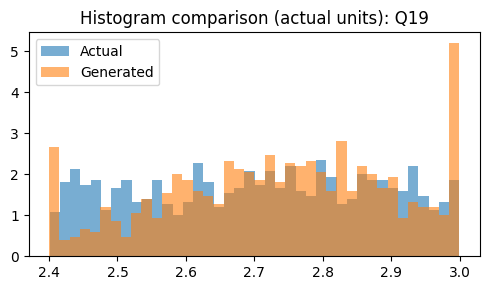

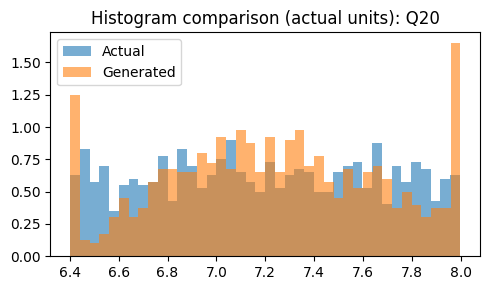

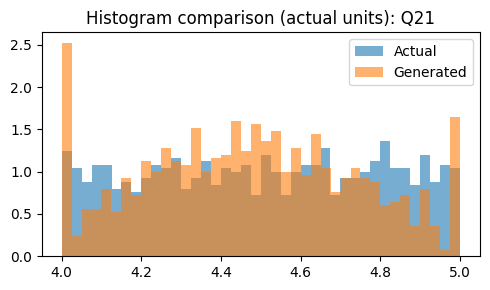

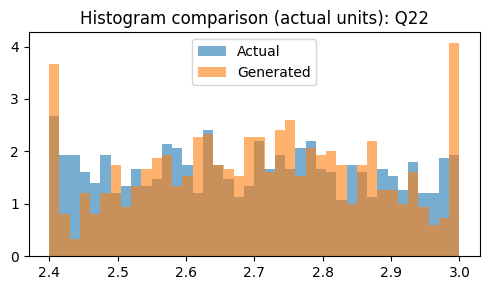

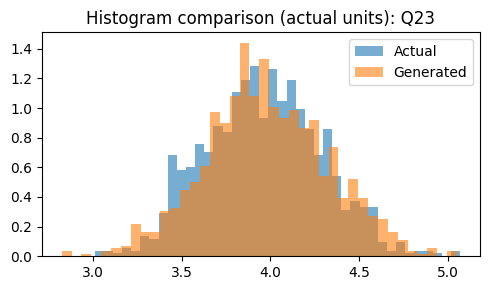

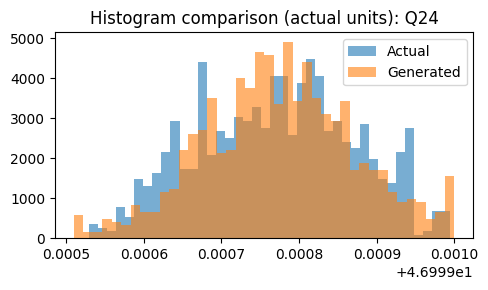

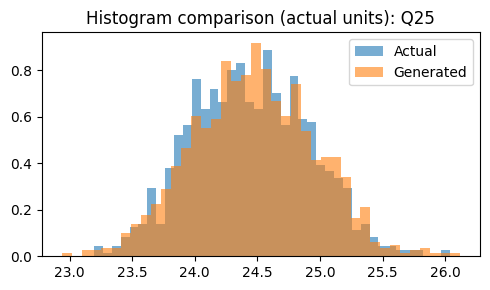

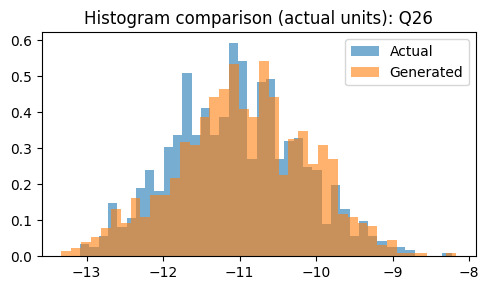

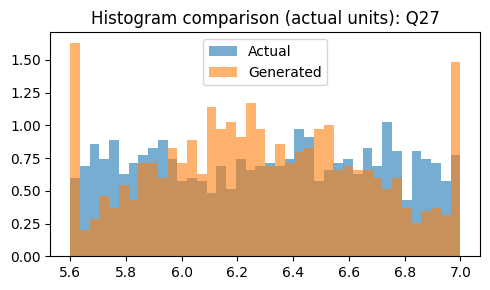

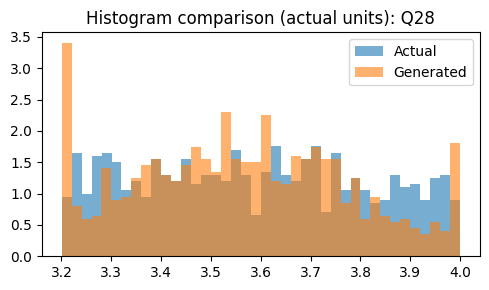

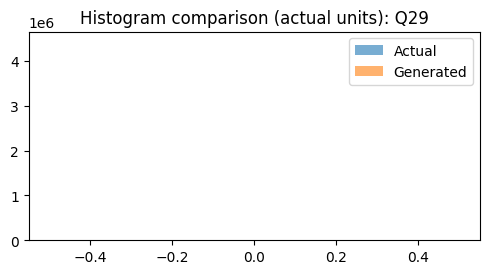

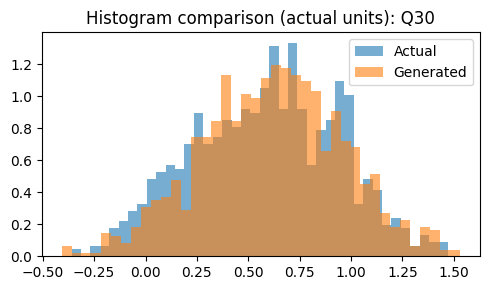

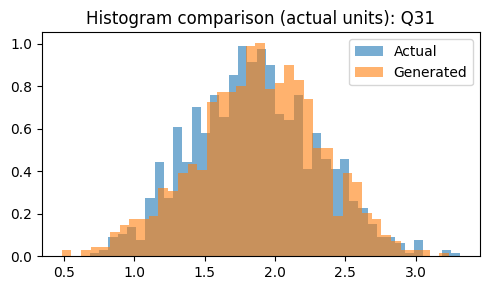

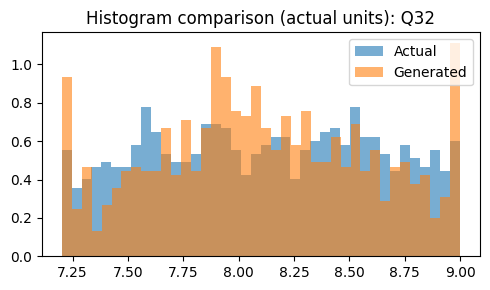

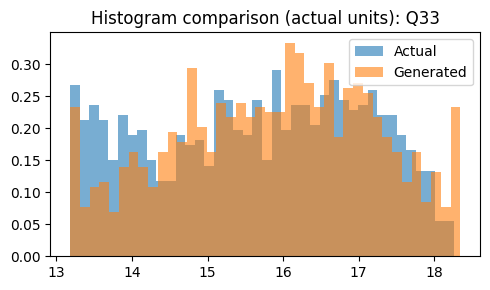

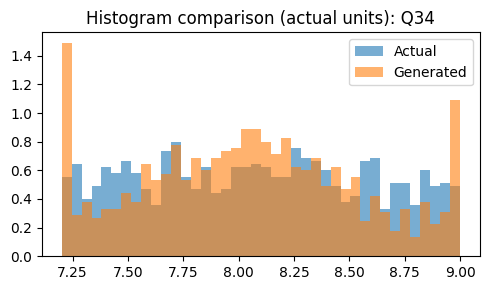

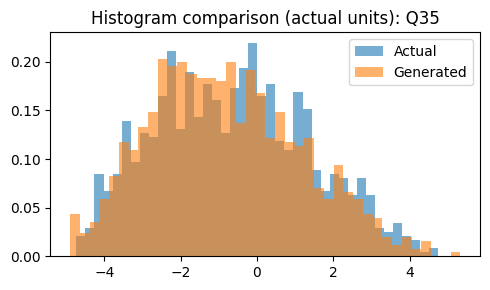

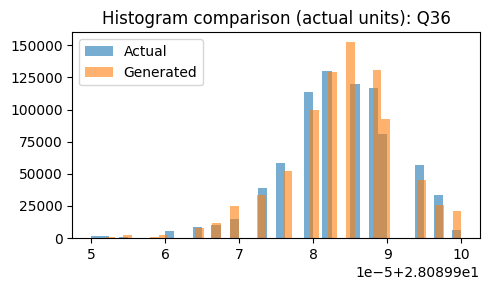

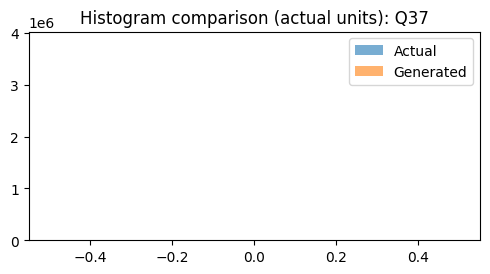

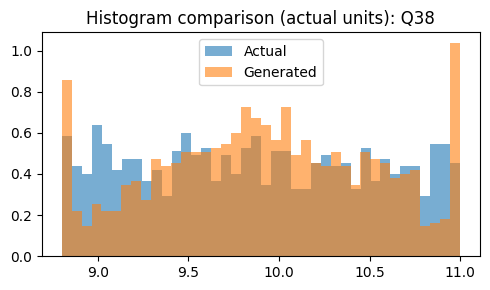

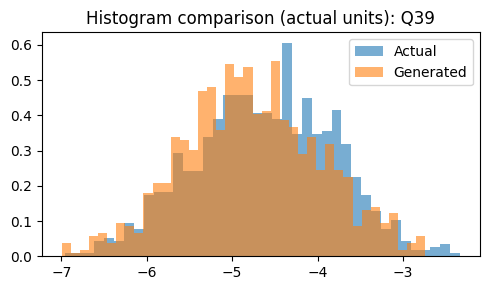

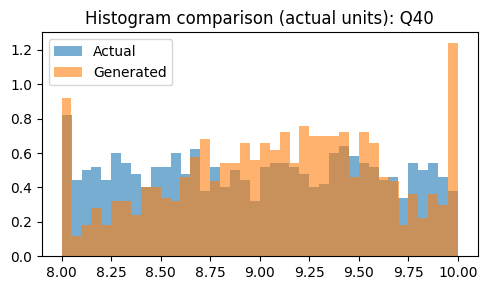

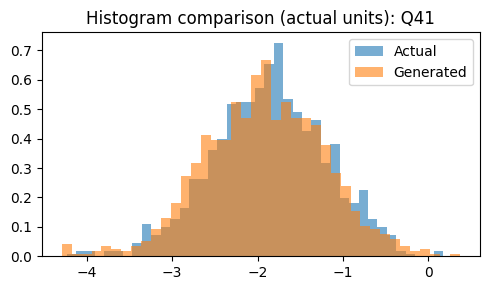

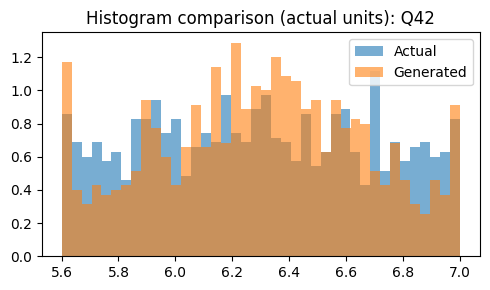

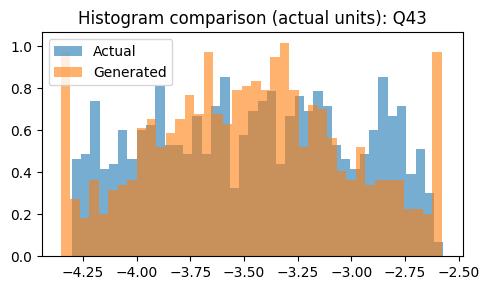

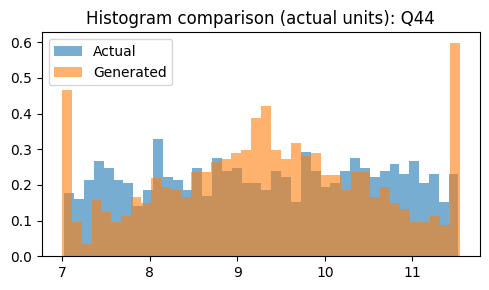

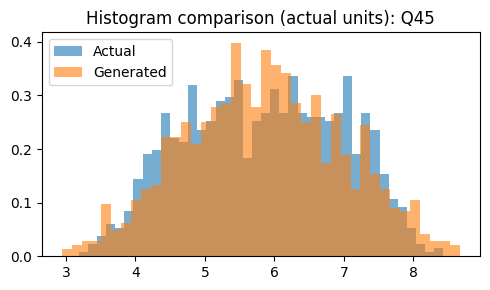

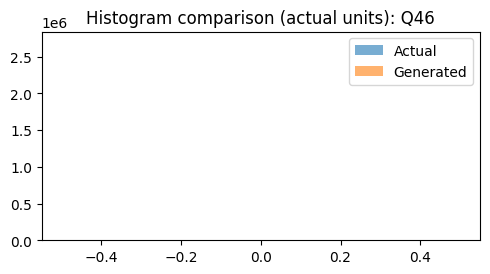

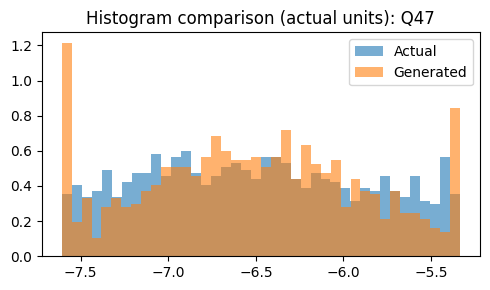

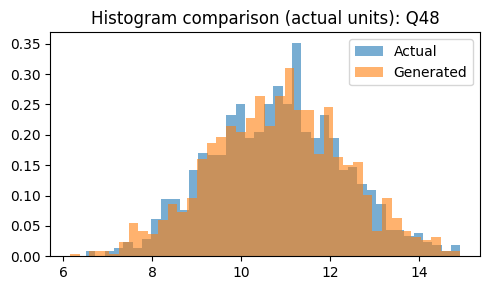

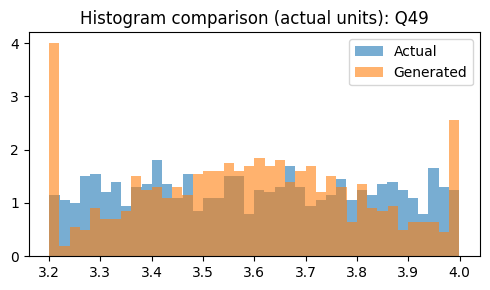

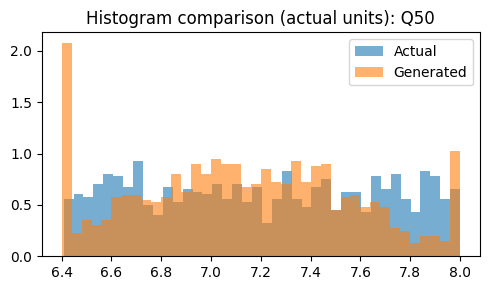

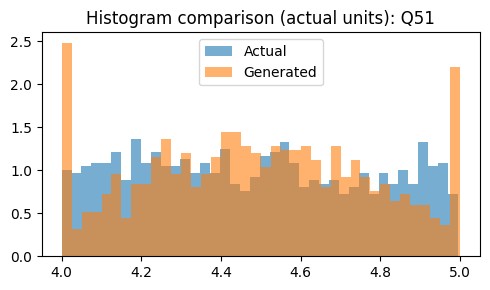

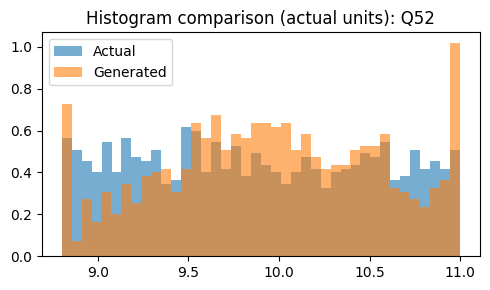

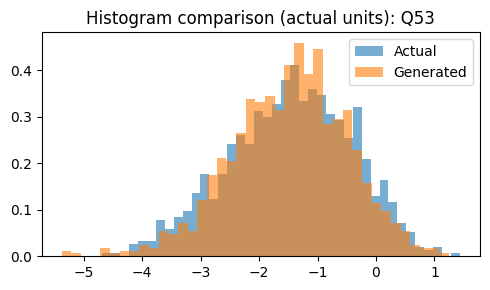

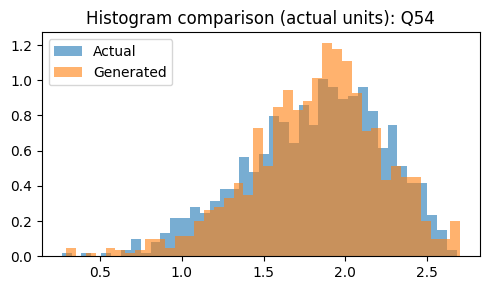

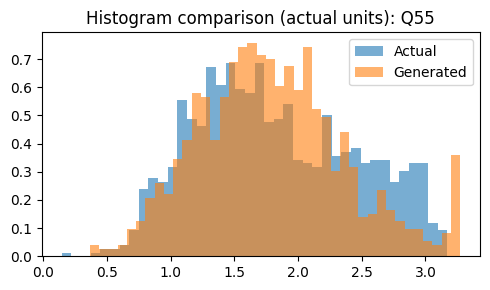

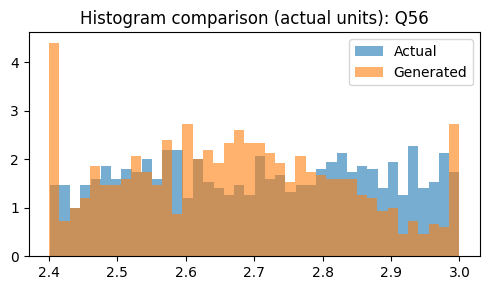

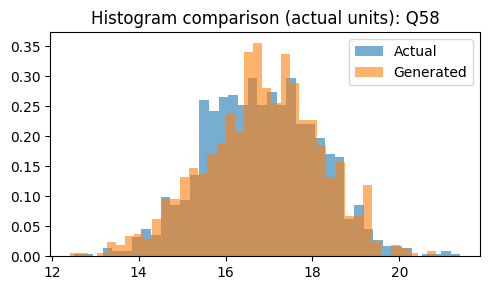

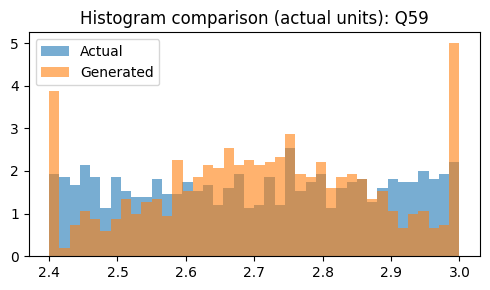

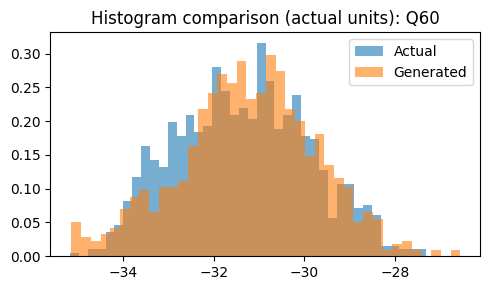

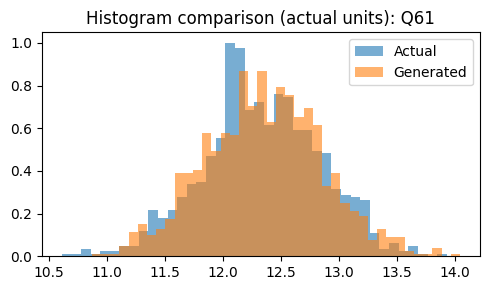

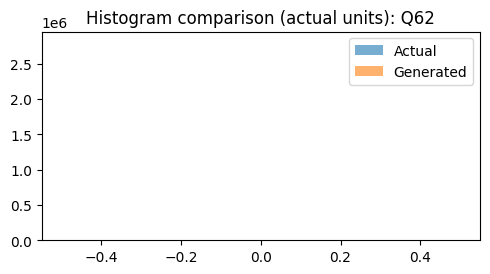

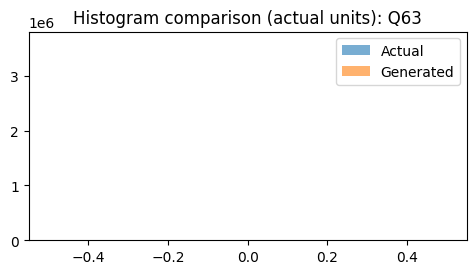

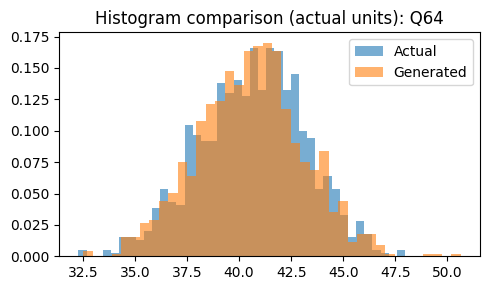

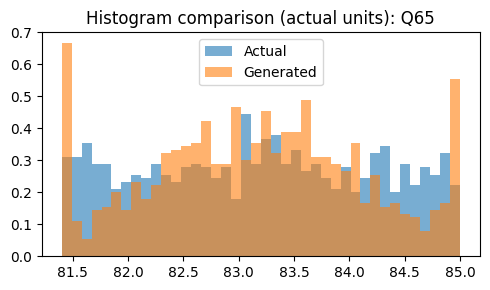

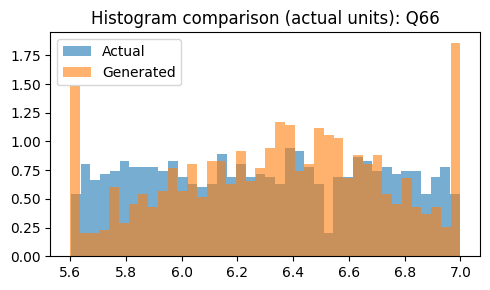

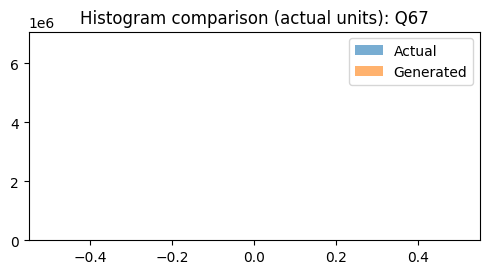

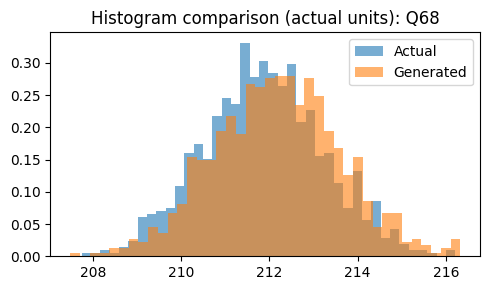

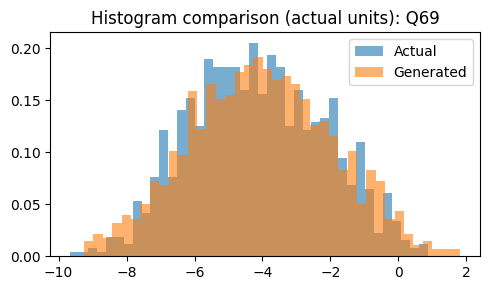

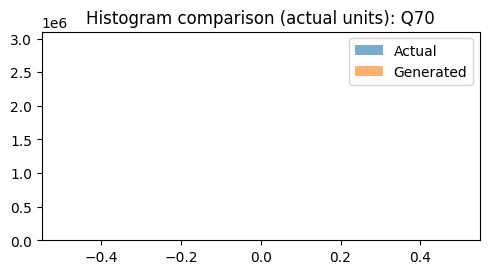

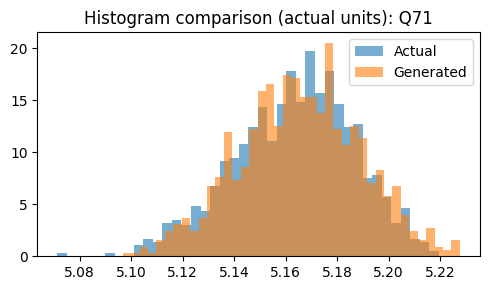

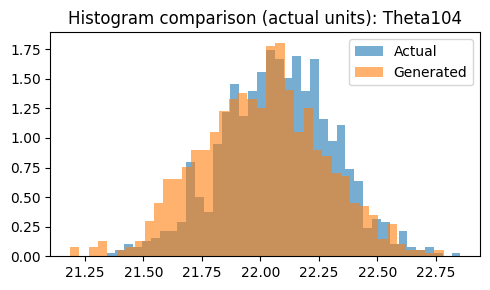

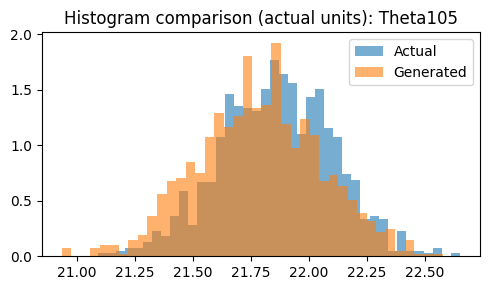

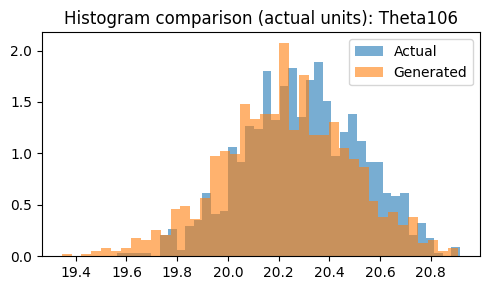

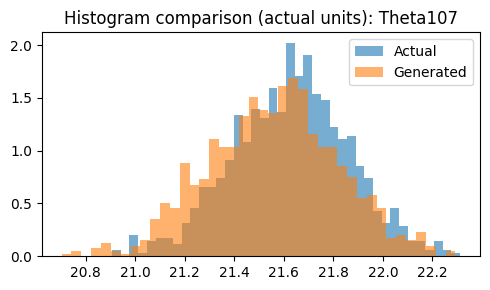

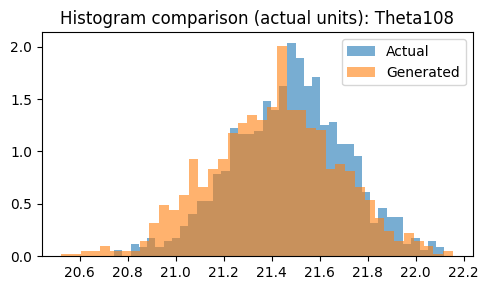

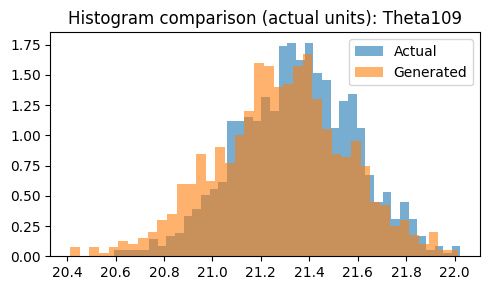

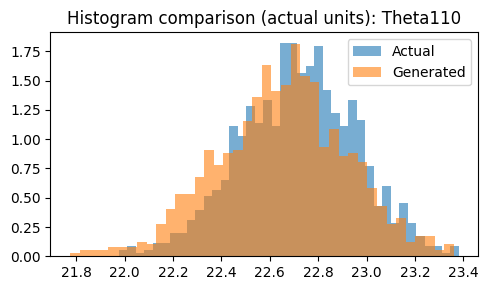

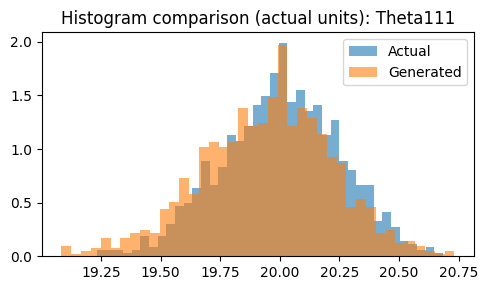

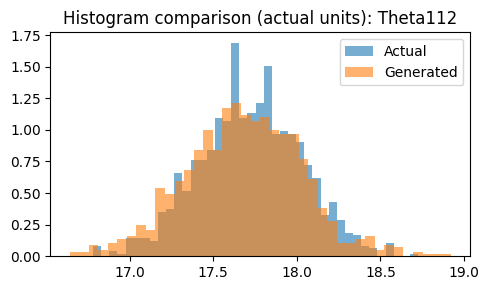

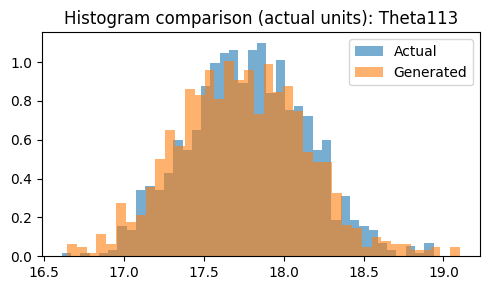

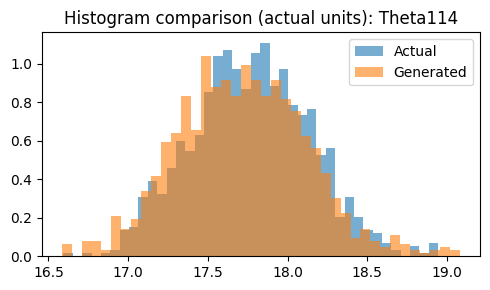

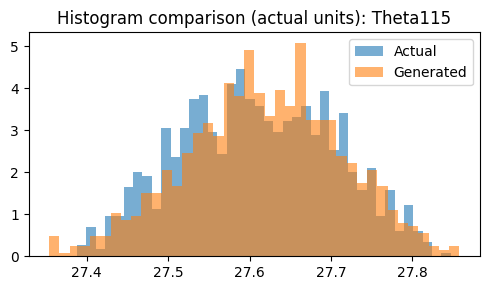

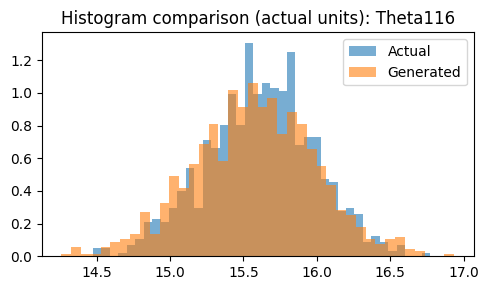

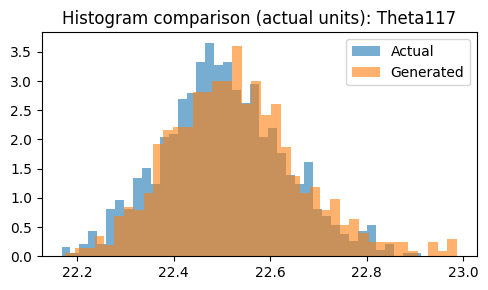

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
p_cols = [c for c in actual.columns if c.startswith("P")]
q_cols = [c for c in actual.columns if c.startswith("Q")]
v_cols = [c for c in actual.columns if c.startswith("V")]
theta_cols = [c for c in actual.columns if c.startswith("Th")]

num_buses = len(p_cols)
print(f"\nDetected {num_buses} buses based on column naming (P1...P{num_buses}).")

# -------------------------------
# Convert per-unit → actual values
# -------------------------------
actual_nonpu = actual.copy()
generated_nonpu = generated.copy()

# Convert P and Q (per-unit → MW / Mvar)
for col in p_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

for col in q_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

# Convert V (per-unit → kV)
vn_kv = net.bus.vn_kv.values  # base voltage for each bus
for i, col in enumerate(v_cols):
    actual_nonpu[col] = actual[col] * vn_kv[i]
    generated_nonpu[col] = generated[col] * vn_kv[i]

# Keep θ in degrees (already real-world unit)
# -------------------------------

print("\nConverted per-unit values to actual units (MW / Mvar / kV / degrees)")

# -------------------------------
# Histogram Comparison (actual units)
# -------------------------------
for col in actual_nonpu.columns:
    plt.figure(figsize=(5,3))
    plt.hist(actual_nonpu[col], bins=40, alpha=0.6, density=True, label='Actual')
    plt.hist(generated_nonpu[col], bins=40, alpha=0.6, density=True, label='Generated')
    plt.title(f"Histogram comparison (actual units): {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()
